In [15]:
import pyvista as pv
from seagullmesh import Mesh3
import numpy as np
import pymeshfix
from ga_population import *
import numpy as np
from sklearn.decomposition import PCA
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from scipy.stats import pearsonr
import warnings

pm_monkey = ProbeMesh.load(
    mesh_file=r"D:\mesh_extract_work\VervertMonkey\JF0N2N0B_VervetMonkeys_Blender\JF0N2N0B_VervetMonkeys_Blender\JF0N2N0B_VervetMonkeys_Run_v4_mesh_extraction.ply",
    img_file=r"C:\corpus2_temp\JF0N2N0B_VervetMonkeys_Run_v4_orig_Main.png",
    index='JC0L219A2_GreyTabbyCat_Trot_v4_orig_Main.png',
    cam_pos=(-0.883204, -1.11311, 1.03748),
    tgt_pos=(0.062604, 0.152099, 0.187549),
    repair=True,
    fill_holes=True,
    cache=True,
    recache=False,
    wrap=True,
    relative_alpha=600,
    relative_offset=1000,
    simplify_n_faces=3000,
)

pm_cat = ProbeMesh.load(
    mesh_file=r"D:\mesh_extract_work\GreyTabbyCat\JC0L219A2_GreyTabbyCat_Blender\JC0L219A2_GreyTabbyCat_Blender\JC0L219A2_GreyTabbyCat_Trot_v4.mesh_extraction2.ply",
    img_file=r"C:\corpus2_temp\JC0L219A2_GreyTabbyCat_Trot_v4_orig_Main.png",
    index='JF0N2N0B_VervetMonkeys_Run_v4_orig_Main.png',
    cam_pos=(-0.19411747, -0.86916119,  0.33897164),
    tgt_pos=( 2.28889287e-04, -3.71107072e-01,  1.14519626e-01),
    repair=True,
    fill_holes=True,
    cache=True,
    recache=False,
    wrap=True,
    relative_alpha=100,
    relative_offset=600,
    simplify_n_faces=3000,
) 

pm_hare = ProbeMesh.load(
    mesh_file=r"D:\mesh_extract_work\SnowshoeHare\JU0L219A1_SnowshoeHare_Summer_Blender\JU0L219A1_SnowshoeHare_Summer_Jump_v4_A_mesh_extraction.ply",
    index='JU0L219A1_SnowshoeHare_Summer_Jump_v4_A_orig_Main.png',
    img_file=r"C:\corpus2_temp\JU0L219A1_SnowshoeHare_Summer_Jump_v4_A_orig_Main.png",
    cam_pos=(-0.52659595, -0.80872011,  0.40757233),
    tgt_pos=(0.019130593165755272, -0.4574986398220062, 0.13628436625003815),
    repair=True,
    fill_holes=True,
    cache=True,
    recache=False,
    wrap=True,
    relative_alpha=600,
    relative_offset=1000,
    simplify_n_faces=3000,
) 

cp_pms = [pm_monkey, pm_cat, pm_hare]

In [16]:
# models = self = SourceModels.current_trained()
# cp_vertex_weights = models.get_weights(cp_pms, expt_kwargs=dict(outputs_at='vertices'))
# torch.save(cp_vertex_weights, 'temp_weights.pt')

cp_vertex_weights = torch.load('temp_weights.pt')

In [4]:
# # PRINCIPLE COMPONENTS - PLOT SEPARATE

# for pm, weights in zip(cp_pms, cp_vertex_weights):
#     pm.plot_weights(weights=weights.pca(), shape=(1, 3), window_size=(1500, 500), scalar_bar=True, titles=['PC1', 'PC2', 'PC3'], render=False)

In [5]:
# # PRINCIPLE COMPONENTS - PLOT RGB

# plotter = pv.Plotter(shape=(1, 3))
# for i, (pm, weights) in enumerate(zip(cp_pms, cp_vertex_weights)):
#     plotter.subplot(0, i)
#     plotter.camera = pm.camera
#     plotter.add_mesh(pm.mesh, scalars=weights.pca(), rgb=True)
# plotter.show()

In [5]:
models = SourceModels.current_trained()

In [19]:
# cp_pm_preds = models.get_predictions(pms)
# torch.save(cp_pm_preds, 'temp_preds.pt')

cp_pm_preds = torch.load('temp_preds.pt')

In [20]:
# cp_responses = models.cp_responses.loc[preds.index]
# cp_responses.to_hdf('cp_responses.hdf', key='cp_responses')

cp_responses = pd.read_hdf('cp_responses.hdf', key='cp_responses')

In [21]:
rvals = np.zeros(preds.shape[1])
for i, (unit_idx, r_mesh) in enumerate(cp_pm_preds.items()):
    r_corpus = cp_responses.loc[:, unit_idx]
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        rvals[i] = pearsonr(r_mesh, r_corpus).statistic
rvals[np.isnan(rvals)] = -1
best_units = cp_responses.columns[np.argsort(rvals)[::-1]]

In [43]:
def load_unit_best(model_idx: int, channel_idx: int, n_best: int):
    model = models[model_idx]
    meta = model.reader.metadata
    scenes, responses, weights, fit_fns = meta.load_data(weights=meta.weight_error)
    cp_weights = pm_weights[model_idx]
    channel = meta.channel[channel_idx]
    unit_responses = responses.iloc[:, channel].sort_values(ascending=False)
    unit_best_scenes = unit_responses.index[:n_best]

    # Load the meshes
    ga_pms = list(ProbeMesh.load_ga_stim(meta.opts.data_dir, scenes.loc[unit_best_scenes]))

    # Present the meshes to the network to get vertex weights
    dataset = GaDataset(
        df=scenes.loc[unit_best_scenes],  # type: ignore
        responses=responses.loc[unit_best_scenes],  # type: ignore
        root_dir=meta.opts.data_file.parent,
        k_eig=meta.k_eig,
        op_cache_dir=meta.opts.data_dir / 'op_cache',
        file_mode=meta.opts.mesh_file_mode,
        weights=meta.weight_error,
        use_visible=meta.use_visible,
        use_color=meta.use_color,
        norm_verts=meta.norm_verts,
        features=meta.input_features,
        augment=None,
    )
    dataloader = DataLoader(dataset, shuffle=False, batch_size=None)
    expt = model.reader.experiment(outputs_at='vertices')
    assert expt.model.outputs_at == 'vertices'
    _ga_obs, ga_weights = expt.predict(dataloader, agg_fn=lambda x: x)
    ga_weights = [VertexWeights(weights=w) for w in ga_weights]

    return ga_pms, ga_weights

In [39]:
def plot_images(pms: list[ProbeMesh], vertex_weights: list[VertexWeights], channel_idx: int, img_sz=(5, 5)):
    img_sz = np.array(img_sz)
    n = len(pms)
    fig, axs = plt.subplots(2, n, figsize=(img_sz[0] * n, img_sz[1] * 2), squeeze=False)
    for axs_i, pm, vw in zip(axs.T, pms, vertex_weights):
        rendered_weights = pm.render(
            weights=vw.weights[:, channel_idx], 
            ground=False, 
            show_scalar_bar=False, 
            window_size=(1024, 1024),
        )
        rendered_image = PIL.Image.open(pm.img_file)
        
        for ax, img in zip(axs_i, (rendered_weights, rendered_image)):
            ax.imshow(img)
            ax.axis('off')
    fig.tight_layout()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.85it/s]


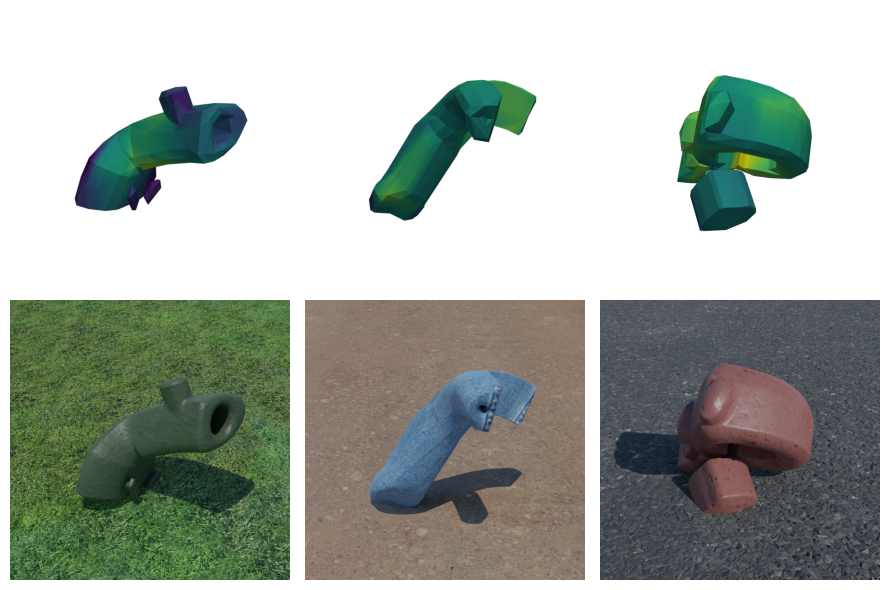

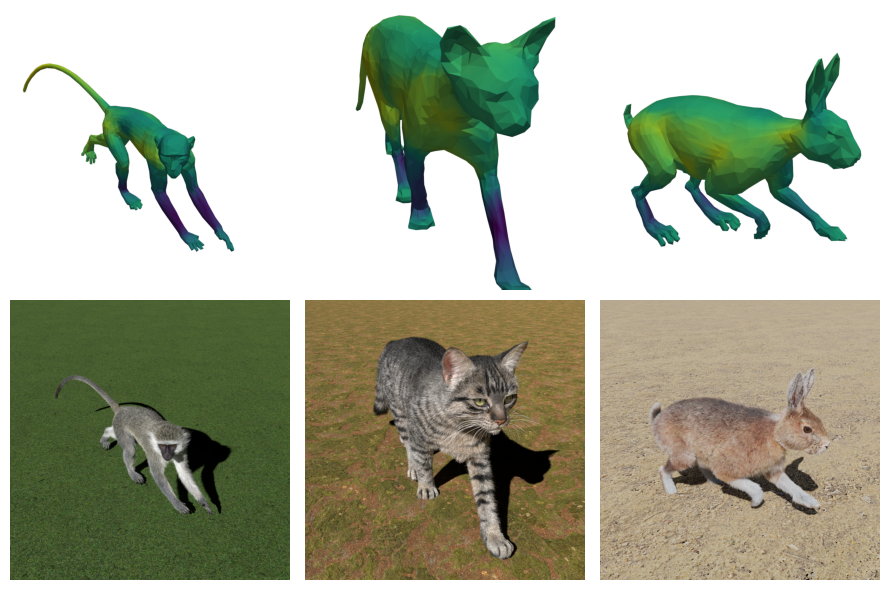

In [44]:
model_idx, channel_idx = best_units[0]
ga_pms, ga_vertex_weights = load_unit_best(model_idx=model_idx, channel_idx=channel_idx, n_best=3)
plot_images(ga_pms, ga_vertex_weights, channel_idx=channel_idx, img_sz=(3, 3))

idx = cp_responses.columns == (model_idx, channel_idx)
this_unit_vws = [VertexWeights(vw.weights[:, idx]) for vw in cp_vertex_weights]
plot_images(cp_pms, this_unit_vws, channel_idx=0, img_sz=(3, 3))